In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv("spotify_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            8582 non-null   object 
 1   track_name          8582 non-null   object 
 2   track_number        8582 non-null   int64  
 3   track_popularity    8582 non-null   int64  
 4   explicit            8582 non-null   bool   
 5   artist_name         8579 non-null   object 
 6   artist_popularity   8582 non-null   int64  
 7   artist_followers    8582 non-null   int64  
 8   artist_genres       5221 non-null   object 
 9   album_id            8582 non-null   object 
 10  album_name          8582 non-null   object 
 11  album_release_date  8582 non-null   object 
 12  album_total_tracks  8582 non-null   int64  
 13  album_type          8582 non-null   object 
 14  track_duration_min  8582 non-null   float64
dtypes: bool(1), float64(1), int64(5), object(8)
memory usag

In [4]:
df.describe()

,track_number,track_popularity,artist_popularity,artist_followers,album_total_tracks,track_duration_min
count,8582.000000,8582.000000,8582.000000,8.582000e+03,8582.000000,8582.000000
mean,5.772547,52.356211,69.730016,2.403472e+07,13.789443,3.492805
std,6.052792,23.816076,19.645979,3.803180e+07,11.887131,1.057970
min,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.070000
25%,1.000000,39.000000,60.000000,4.623200e+05,6.000000,2.880000
50%,4.000000,58.000000,74.000000,6.105547e+06,13.000000,3.445000
75%,9.000000,71.000000,84.000000,2.725255e+07,17.000000,3.990000
max,102.000000,99.000000,100.000000,1.455421e+08,181.000000,13.510000


<Axes: >

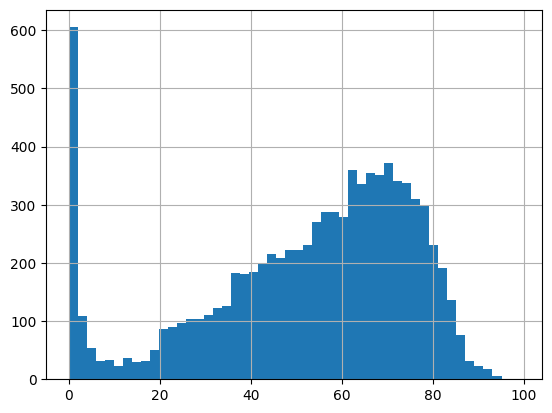

In [5]:
df['track_popularity'].hist(bins=50)

In [6]:
df['is_banger'] = (df['track_popularity'] > 60).astype(int)

In [7]:
df['is_banger'].value_counts(normalize=True)

is_banger
0    0.54323
1    0.45677
Name: proportion, dtype: float64

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.columns = df.columns.str.lower().str.replace(' ','_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numeric_columns = list(set(df.columns) - set(categorical_columns))

In [10]:

for c in categorical_columns:
    df[c] = (
        df[c]
        .fillna("unknown")
        .astype(str)
        .str.lower()
        .str.replace(' ', '_')
    )


In [11]:
from sklearn.impute import SimpleImputer; 
imp = SimpleImputer(strategy='median'); 
df[numeric_columns] = imp.fit_transform(df[numeric_columns])

In [12]:
df.isnull().sum()

track_id              0
track_name            0
track_number          0
track_popularity      0
explicit              0
artist_name           0
artist_popularity     0
artist_followers      0
artist_genres         0
album_id              0
album_name            0
album_release_date    0
album_total_tracks    0
album_type            0
track_duration_min    0
is_banger             0
dtype: int64

okay so got the dataset...
1. got the problem statment, found the target variable..
2. extracted a meaingfull attributes from it and now onto doing basic feature engineering 3. then will do some EDA on it...
4. then do the training_test split..
5. fit the model on logistic reg, Dt, randomforest before...
6. then finetune the parameters...and show 7. the final difference in form of graph...
8. then pickle the model..
9. check the model prediction in another notevook..
10. create train.py
11. download the model file....
12. create a pipenv env and pipfile..
13. create a predict.py(flask deploymnet)
14. check the pipenv deployment in local host..
15. then create the docker image..
16. deploy it in docker..

In [13]:
columns = ['track_id','track_name','artist_name','album_id','album_name','track_number']
new_df = df.drop(columns=columns)

In [14]:
new_df.head()

,track_popularity,explicit,artist_popularity,artist_followers,artist_genres,album_release_date,album_total_tracks,album_type,track_duration_min,is_banger
0,0.0,1.0,77.0,2812821.0,moombahton,2025-10-31,9.0,album,1.55,0.0
1,0.0,1.0,64.0,2363438.0,"country_hip_hop,_southern_hip_hop",2025-10-31,1.0,single,3.07,0.0
2,4.0,1.0,48.0,193302.0,unknown,2025-10-31,1.0,single,2.55,0.0
3,30.0,1.0,77.0,2813710.0,moombahton,2025-10-31,9.0,album,1.69,0.0
4,0.0,1.0,48.0,8682.0,dark_r&b,2025-10-30,2.0,single,2.39,0.0


In [15]:
new_df['log_track_pop'] = np.log1p(new_df['track_popularity'])

In [16]:
new_df['log_artist_pop'] = np.log1p(new_df['artist_popularity'])

In [17]:
q = new_df['artist_followers'].quantile(0.99);
new_df['artist_followers'] = new_df['artist_followers'].clip(upper=q)
new_df['log_followers'] = np.log1p(new_df['artist_followers'])

In [18]:
counts = new_df['artist_genres'].value_counts()
threshold = 70
rare_genre = counts[counts <= threshold].index
new_df['artist_genres_clean'] = new_df['artist_genres'].replace(rare_genre,'Others')
genre_dummies = pd.get_dummies(new_df['artist_genres_clean'], prefix='genre')
new_df = pd.concat([new_df, genre_dummies], axis=1)

In [19]:
new_df['album_release_date'] = pd.to_datetime(
    new_df['album_release_date'],
    errors='coerce')

In [20]:
new_df['album_release_date'] = pd.to_datetime(new_df['album_release_date'], errors='coerce')

In [21]:
new_df['release_year'] = new_df['album_release_date'].dt.year
new_df['release_month'] = new_df['album_release_date'].dt.month
new_df['release_age'] = 2025 - new_df['release_year']  
new_df = new_df.drop(columns=['album_release_date'])

In [22]:
new_df['log_album_tracks'] = np.log1p(new_df['album_total_tracks'])

In [23]:
new_df = pd.get_dummies(new_df, columns=['album_type'], prefix='type')

In [24]:
new_df['log_duration'] = np.log1p(new_df['track_duration_min'])

In [25]:
    new_df = new_df.drop(columns=['track_popularity','artist_popularity','artist_followers','album_total_tracks','log_track_pop'])

In [26]:
new_df.head()

,explicit,artist_genres,track_duration_min,is_banger,log_artist_pop,log_followers,artist_genres_clean,genre_Others,"genre_alternative_pop,_indie_pop",genre_country,...,genre_soundtrack,genre_unknown,release_year,release_month,release_age,log_album_tracks,type_album,type_compilation,type_single,log_duration
0,1.0,moombahton,1.55,0.0,4.356709,14.849699,Others,True,False,False,...,False,False,2025,10,0,2.302585,True,False,False,0.936093
1,1.0,"country_hip_hop,_southern_hip_hop",3.07,0.0,4.174387,14.675628,Others,True,False,False,...,False,False,2025,10,0,0.693147,False,False,True,1.403643
2,1.0,unknown,2.55,0.0,3.891820,12.172014,unknown,False,False,False,...,False,True,2025,10,0,0.693147,False,False,True,1.266948
3,1.0,moombahton,1.69,0.0,4.356709,14.850015,Others,True,False,False,...,False,False,2025,10,0,2.302585,True,False,False,0.989541
4,1.0,dark_r&b,2.39,0.0,3.891820,9.069122,dark_r&b,False,False,False,...,False,False,2025,10,0,1.098612,False,False,True,1.220830


In [27]:
from sklearn.model_selection import train_test_split

X = new_df.drop('is_banger', axis=1)
y = new_df['is_banger']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

df_train = X_train.copy(); df_train['is_banger'] = y_train  # For EDA
df_val = X_val.copy(); df_val['is_banger'] = y_val
df_test = X_test.copy(); df_test['is_banger'] = y_test

del df_train['is_banger']
del df_val['is_banger']
del df_test['is_banger']

In [28]:
X.columns

Index(['explicit', 'artist_genres', 'track_duration_min', 'log_artist_pop',
       'log_followers', 'artist_genres_clean', 'genre_Others',
       'genre_alternative_pop,_indie_pop', 'genre_country',
       'genre_country,_acoustic_country', 'genre_country,_pop,_indie,_folk',
       'genre_dark_r&b', 'genre_edm', 'genre_grunge,_rock', 'genre_k-pop',
       'genre_pop', 'genre_pop,_hip_hop,_country',
       'genre_r&b_pop,_alternative_r&b,_hip_hop,_synthpop', 'genre_rap',
       'genre_rap,_hip_hop', 'genre_soft_pop', 'genre_soundtrack',
       'genre_unknown', 'release_year', 'release_month', 'release_age',
       'log_album_tracks', 'type_album', 'type_compilation', 'type_single',
       'log_duration'],
      dtype='object')

In [29]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
train_dicts = df_train[df_train.columns].to_dict(orient='records')


X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[df_val.columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)



In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=10, 
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)



features = [str(f) for f in dv.get_feature_names_out()]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params ={
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective': 'binary:logistic',
    'nthread':8,

    'seed':1,
    'verbosity':1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=10)


In [31]:
from sklearn.metrics import roc_auc_score
print("Results  of the models without fine-tuning:-")

y_pred = lr.predict_proba(X_val)[:,1]
r1 = roc_auc_score(y_val, y_pred)
print("LogR predicts := ",r1)

y_pred = dt.predict_proba(X_val)[:,1]
r2 = roc_auc_score(y_val, y_pred)
print("DT predicts := ",r2)

y_pred = rf.predict_proba(X_val)[:,1]
r3 = roc_auc_score(y_val, y_pred)
print("RF predicts := ",r3)

y_pred = model.predict(dval)
r4 = roc_auc_score(y_val,y_pred)
print("XGB predicts := ",r4)

Results  of the models without fine-tuning:-
LogR predicts :=  0.8082339447032832
DT predicts :=  0.7679002067064769
RF predicts :=  0.8068852943106503
XGB predicts :=  0.8158172835050419


In [32]:
for d in [6,7,8,9,10,11,12,13,15,20,None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d,auc))

   6 -> 0.761
   7 -> 0.780
   8 -> 0.790
   9 -> 0.785
  10 -> 0.779
  11 -> 0.780
  12 -> 0.765
  13 -> 0.756
  15 -> 0.760
  20 -> 0.738
None -> 0.713


In [33]:
scores = []

for d in [8,9,10]:
    for s in [1,2,5,15,20,100,200,500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [34]:
columns = ['max_depth', 'min_sample_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_sample_leaf',
                                  columns=['max_depth'],values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth           8      9      10
min_sample_leaf                     
1                0.786  0.790  0.778
2                0.784  0.785  0.782
5                0.800  0.798  0.801
15               0.799  0.807  0.809
20               0.798  0.808  0.808
100              0.791  0.789  0.789
200              0.769  0.769  0.769
500              0.741  0.741  0.741

<Axes: xlabel='None-max_depth', ylabel='min_sample_leaf'>

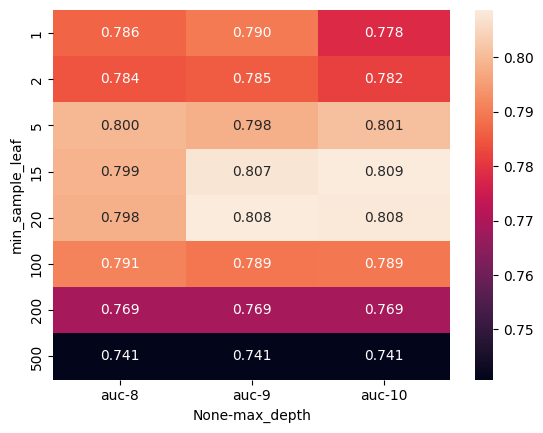

In [35]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

from the above graph we conclude that the best max_depth for our DT is 10 and best min_Sample is 20

In [36]:
acores = []

for d in [5,10, 15, 20]:
    for n in range(10, 200, 10):
        rf = RandomForestClassifier(n_estimators=n,max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        acores.append((d,n,auc))
df_rf = pd.DataFrame(acores, columns = ['max_depth','estimators','auc'])


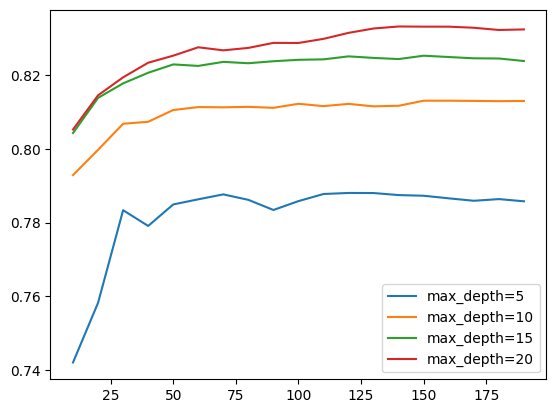

In [37]:
for d in [5,10,15,20]:
    df_subset = df_rf[df_rf.max_depth == d]
    plt.plot(df_subset.estimators, df_subset.auc,
    label='max_depth=%d' %d)

plt.legend()

In [38]:
max_depth = 20

acores = []
for s in [1, 3, 5, 10]:
    for n in [10, 50, 100, 150]:
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depth, 
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        acores.append((s,n,auc))

df_acores = pd.DataFrame(acores, columns =['min_samples_leaf','n_estimators','auc'])

In [39]:
colors = ['black','blue','orange','red','grey']
min_sample_leaf_values = [1, 3, 5, 10, 50]
list(zip(min_sample_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

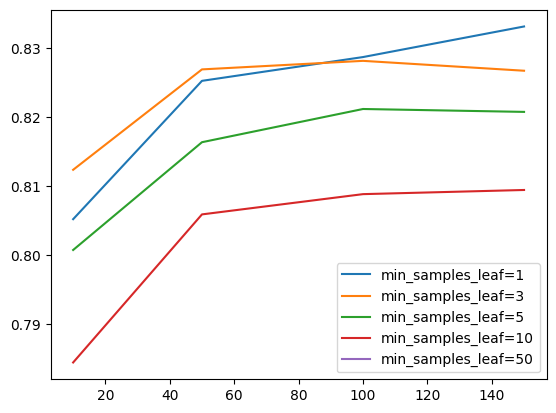

In [40]:
colors = ['black','blue','orange','red','grey']
min_sample_leaf_values = [1, 3, 5, 10, 50]

for s in [1, 3, 5, 10, 50]:
    df_subset = df_acores[df_acores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc,
    label='min_samples_leaf=%d' % s)

plt.legend()

hence from the above 2 graphs we conclude the optimal max_depth and min_sample_leaf for the RF is 10 and 3

In [41]:
watchlist = [(dtrain,'train'),(dval, 'val')]

In [42]:

%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective': 'binary:logistic',
    'eval_metric':'auc',
    
    'nthread':8,
    'seed':1,
    'verbosity':1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                 evals=watchlist)


In [43]:
s = output.stdout

In [44]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it,train,val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

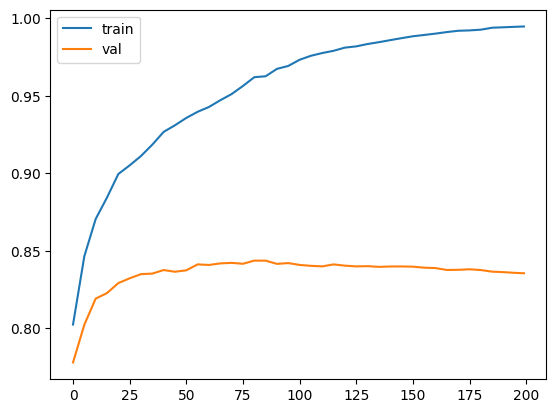

In [45]:
df_xg = parse_xgb_output(output)
plt.plot(df_xg.num_iter, df_xg.train_auc, label='train')
plt.plot(df_xg.num_iter, df_xg.val_auc, label='val')
plt.legend()

In [46]:
# final model selection after finetuning:-
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20)
dt.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=10, 
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)



features = [str(f) for f in dv.get_feature_names_out()]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params ={
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective': 'binary:logistic',
    'nthread':8,

    'seed':1,
    'verbosity':1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=10)


In [47]:
from sklearn.metrics import roc_auc_score
print("Results  of the models after fine-tuning:-")

y_pred = lr.predict_proba(X_val)[:,1]
r1 = roc_auc_score(y_val, y_pred)
print("LogR predicts := ",r1)

y_pred = dt.predict_proba(X_val)[:,1]
r2 = roc_auc_score(y_val, y_pred)
print("DT predicts := ",r2)

y_pred = rf.predict_proba(X_val)[:,1]
r3 = roc_auc_score(y_val, y_pred)
print("RF predicts := ",r3)

y_pred = model.predict(dval)
r4 = roc_auc_score(y_val,y_pred)
print("XGB predicts := ",r4)

Results  of the models after fine-tuning:-
LogR predicts :=  0.8082339447032832
DT predicts :=  0.8078819148238072
RF predicts :=  0.8068852943106503
XGB predicts :=  0.8158172835050419


In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Assuming you still have X_val, y_val, and your trained xgb model
y_val_pred = (model.predict(dval) > 0.5).astype(int)   # or model.predict(X_val) for sklearn API

print("XGB Validation Report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(pd.DataFrame(cm, 
                   index=['True No-Hit', 'True Hit'], 
                   columns=['Pred No-Hit', 'Pred Hit']))

XGB Validation Report:
              precision    recall  f1-score   support

         0.0       0.84      0.64      0.72       933
         1.0       0.66      0.85      0.75       784

    accuracy                           0.74      1717
   macro avg       0.75      0.75      0.74      1717
weighted avg       0.76      0.74      0.73      1717

Confusion Matrix:
             Pred No-Hit  Pred Hit
True No-Hit          594       339
True Hit             114       670


In [49]:
#random forest prevails hence exporting the rf model for deployment:-
import pickle 
output_file = f'spotify_model.bin'
with open(output_file,'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [53]:
# CELL 1 - Imports + Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

df = pd.read_csv("spotify_data.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_')

print(f"Dataset: {df.shape[0]:,} songs × {df.shape[1]} features")
df.head()

Dataset: 8,582 songs × 15 features


,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48,193302,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,2.39


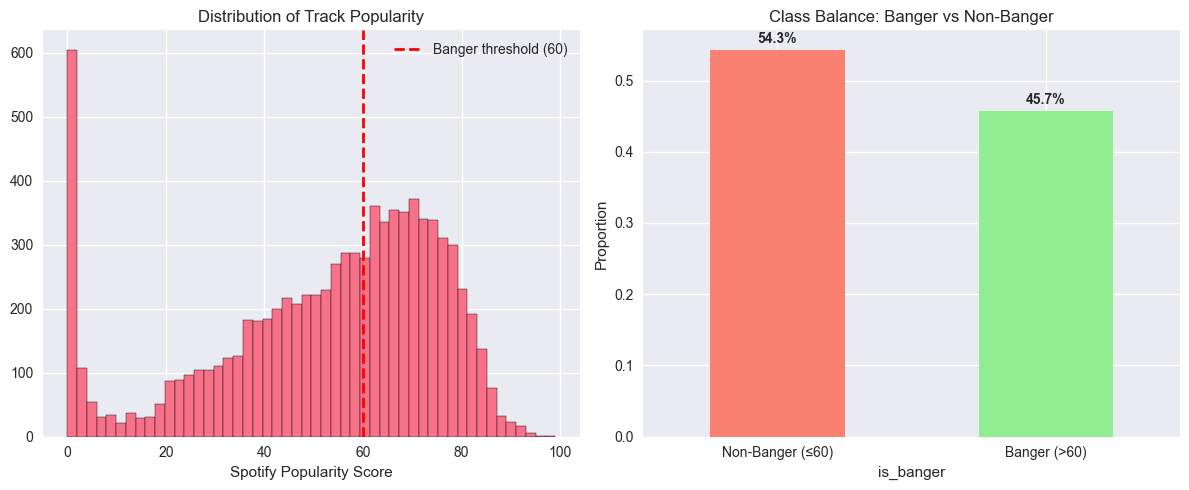

Banger rate: 45.7%


In [54]:
# CELL 2 - Target distribution (the money plot)
df['is_banger'] = (df['track_popularity'] > 60).astype(int)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
df['track_popularity'].hist(bins=50, edgecolor='black')
plt.axvline(60, color='red', linestyle='--', linewidth=2, label='Banger threshold (60)')
plt.title('Distribution of Track Popularity')
plt.xlabel('Spotify Popularity Score')
plt.legend()

plt.subplot(1,2,2)
df['is_banger'].value_counts(normalize=True).plot(kind='bar', color=['salmon', 'lightgreen'])
plt.title('Class Balance: Banger vs Non-Banger')
plt.ylabel('Proportion')
plt.xticks([0,1], ['Non-Banger (≤60)', 'Banger (>60)'], rotation=0)
for i, v in enumerate(df['is_banger'].value_counts(normalize=True)):
    plt.text(i, v+0.01, f"{v:.1%}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Banger rate: {df['is_banger'].mean():.1%}")

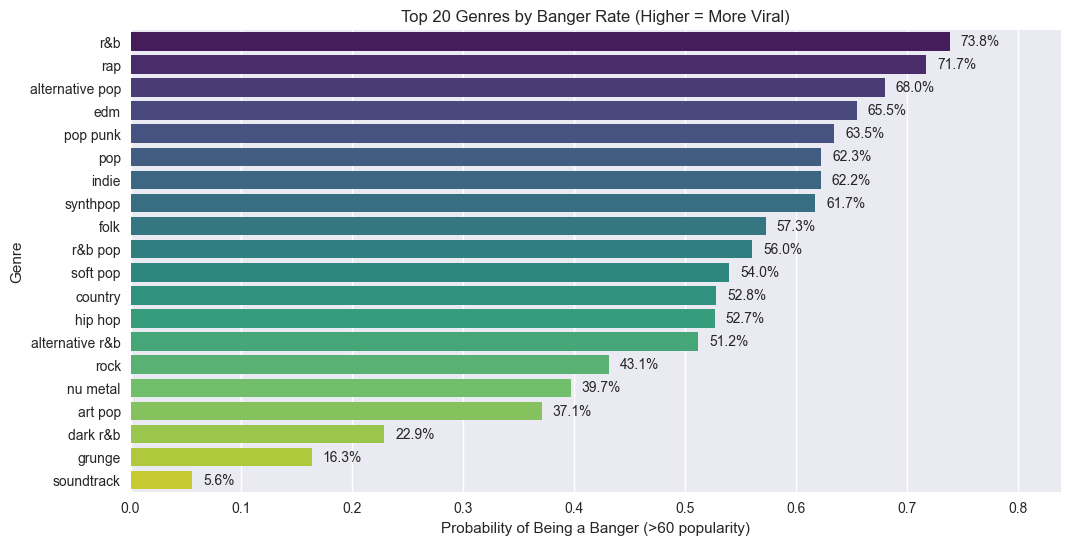

In [55]:
# CELL 3 - Top 15 genres (raw vs banger rate)
top_genres_raw = df['artist_genres'].astype(str).value_counts().head(15)

# Parse genres properly
def parse_genres(x):
    if pd.isna(x): return []
    x = str(x).strip("[]'")
    return [g.strip().strip("'\"") for g in x.split(',') if g.strip()]

df['genres_list'] = df['artist_genres'].apply(parse_genres)
all_genres = [g for sublist in df['genres_list'] for g in sublist if g != 'nan']
genre_counts = pd.Series(all_genres).value_counts()

banger_by_genre = {}
for genre in genre_counts.head(20).index:
    mask = df['genres_list'].apply(lambda x: genre in x)
    banger_rate = df[mask]['is_banger'].mean()
    banger_by_genre[genre] = banger_rate

genre_insight = pd.DataFrame({
    'count': genre_counts.head(20),
    'banger_rate': pd.Series(banger_by_genre)
}).sort_values('banger_rate', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=genre_insight.reset_index(), x='banger_rate', y='index', palette='viridis')
plt.title('Top 20 Genres by Banger Rate (Higher = More Viral)')
plt.xlabel('Probability of Being a Banger (>60 popularity)')
plt.ylabel('Genre')
for i, (idx, row) in enumerate(genre_insight.iterrows()):
    plt.text(row['banger_rate']+0.01, i, f"{row['banger_rate']:.1%}", va='center')
plt.xlim(0, genre_insight['banger_rate'].max() + 0.1)
plt.show()

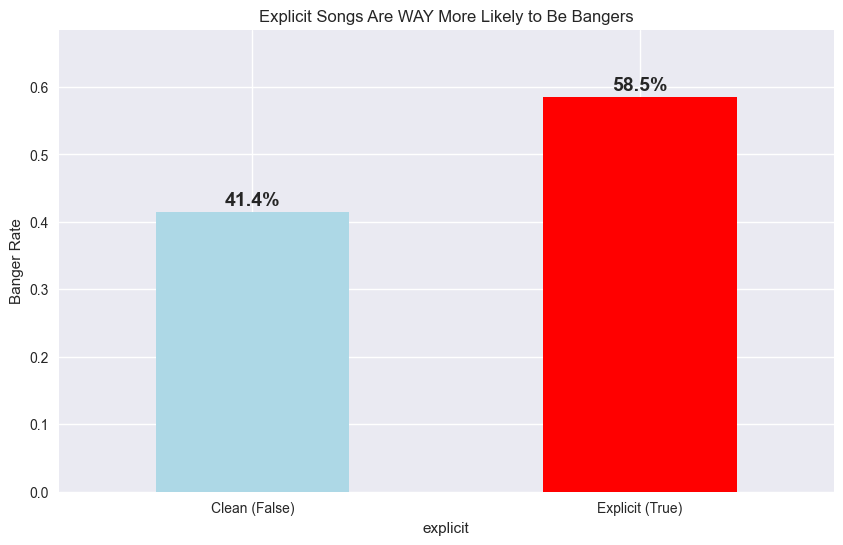

Explicit songs are 1.4x more likely to be bangers!


In [56]:
# CELL 4 - Explicit = Viral? (MASSIVE insight)
plt.figure(figsize=(10,6))
explicit_banger = df.groupby('explicit')['is_banger'].mean()
explicit_banger.plot(kind='bar', color=['lightblue', 'red'])
plt.title('Explicit Songs Are WAY More Likely to Be Bangers')
plt.ylabel('Banger Rate')
plt.xticks([0,1], ['Clean (False)', 'Explicit (True)'], rotation=0)
for i, v in enumerate(explicit_banger):
    plt.text(i, v+0.01, f"{v:.1%}", ha='center', fontweight='bold', fontsize=14)
plt.ylim(0, explicit_banger.max() + 0.1)
plt.show()

print(f"Explicit songs are {explicit_banger[1]/explicit_banger[0]:.1f}x more likely to be bangers!")

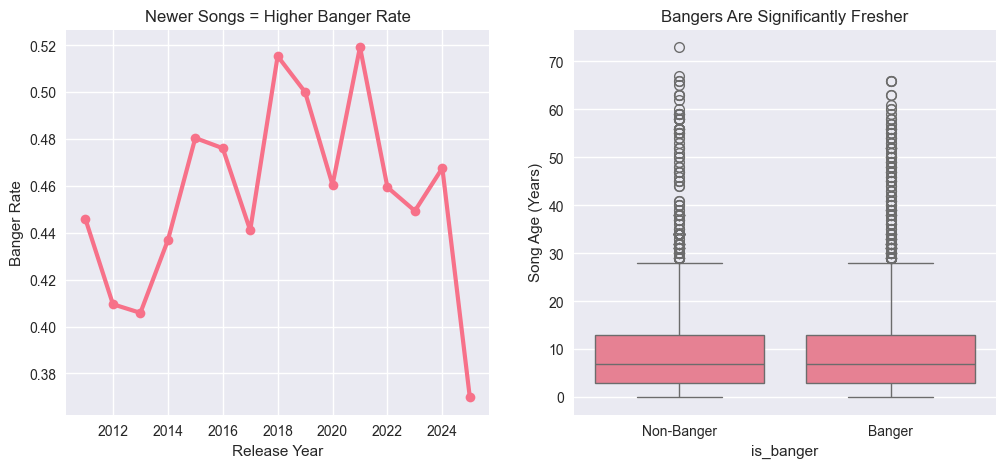

In [57]:
# CELL 5 - Release year & freshness matters
df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')
df['release_year'] = df['album_release_date'].dt.year
df['song_age_years'] = 2025 - df['release_year']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df.groupby('release_year')['is_banger'].mean().tail(15).plot(kind='line', marker='o', linewidth=3)
plt.title('Newer Songs = Higher Banger Rate')
plt.ylabel('Banger Rate')
plt.xlabel('Release Year')

plt.subplot(1,2,2)
sns.boxplot(data=df, x='is_banger', y='song_age_years')
plt.title('Bangers Are Significantly Fresher')
plt.xticks([0,1], ['Non-Banger', 'Banger'])
plt.ylabel('Song Age (Years)')
plt.show()

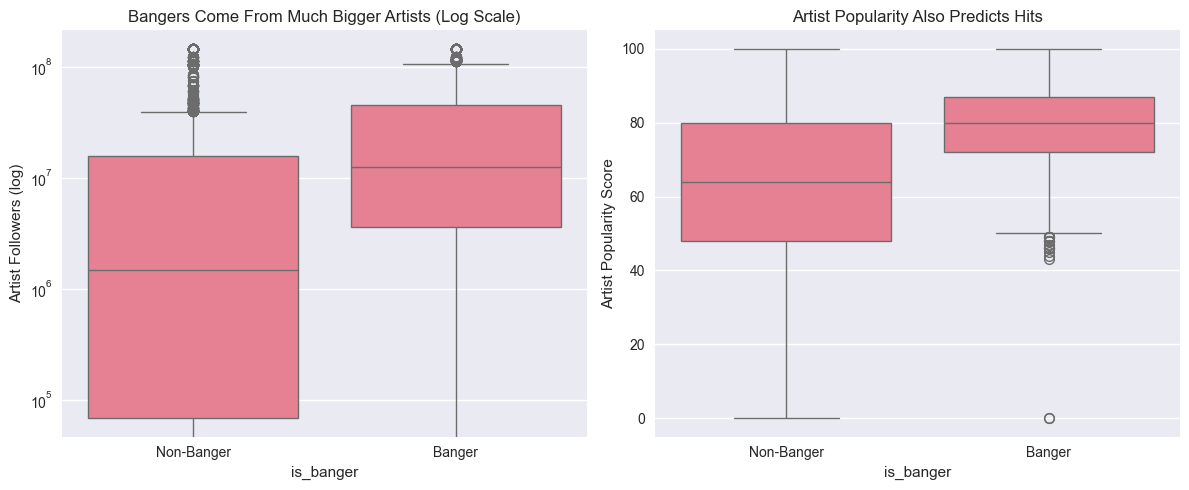

In [58]:
# CELL 6 - Artist followers & popularity (log scale!)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df, x='is_banger', y='artist_followers')
plt.yscale('log')
plt.title('Bangers Come From Much Bigger Artists (Log Scale)')
plt.ylabel('Artist Followers (log)')
plt.xticks([0,1], ['Non-Banger', 'Banger'])

plt.subplot(1,2,2)
sns.boxplot(data=df, x='is_banger', y='artist_popularity')
plt.title('Artist Popularity Also Predicts Hits')
plt.ylabel('Artist Popularity Score')
plt.xticks([0,1], ['Non-Banger', 'Banger'])
plt.tight_layout()
plt.show()